In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [8]:
def createAlignedState(N):
    """
    Returns a state in which every spin is pointing up as an N by N numpy array
    """
    return np.ones([N,N,N])

#def createJArray(state):
#    J = np.random.uniform(size = [state.size, state.size, state.size])
#    J += J.T
#    return J

#def indexToCoord(index, state):
#    return np.unravel_index(index, state.shape)

#def coordToIndex(spin, state):
#    return np.ravel_multi_index(spin, state.shape)

def createRandState(N):
    """
    Returns a state in which every spin is randomized as an N by N numpy array
    """
    return np.random.choice([-1, 1], size = [N,N,N])

def calcTotalEnergy(state, J, mu, B):
    """
    Calculates the total energy in the presence of an external field B with the equation
    E = -J (Sum_neighbors s_i*s_j) - mu * B * (Sum s_i)
    
    args:
        state: a 2d numpy array of +1 or -1
        J: The self coupling term                    array type
        mu: The magnetic moment                      float
        B: The external, applied field               float
    returns:
        Energy: The energy of the state
    """
    (xSize, ySize, zSize) = state.shape
    #JSize = state.size
    Energy = 0
    for x in range(xSize):
        for y in range(ySize):
            for z in range(zSize):
                # Compute the interaction term with the 2 neighbors that are +1 in each direction
                Energy += -J * state[x,y,z] * state[(x+1) % xSize, y, z]
                Energy += -J * state[x,y,z] * state[x, (y+1) % ySize, z]  
                Energy += -J * state[x,y,z] * state[x, y, (z+1) % zSize]
                # Compute the interaction term with the field
                Energy += -mu*B*state[x,y,z]

    return Energy

def pickRandSite(state):
    """
    Returns a randomly chosen site within the state
    """
    (xSize, ySize, zSize) = state.shape
    return (np.random.randint(xSize), np.random.randint(ySize), np.random.randint(zSize))

def calcDeltaE(state, site, J, mu, B):
    """
    Returns the change in energy due to flipping the spin at the given site
    
    args:
        state: a 2d numpy array of +1 or -1
        site: the chosen site
    returns:
        deltaE: The change in energy
    """    
    (xSize, ySize, zSize) = state.shape
    #JSize = state.size
    #print((site[0]+1, site[1]-1))
    deltaEField = 2 * mu * B * state[site] 
    deltaENeighbors = 2 * state[site]*(
              state[(site[0]-1) % xSize, site[1], site[2]]# * J[indexToCoord(coordToIndex(((site[0]-1)%xSize,site[1],site[2]), state), J)]
            + state[(site[0]+1) % xSize, site[1], site[2]]# * J[indexToCoord(coordToIndex(((site[0]+1)%xSize,site[1],site[2]), state), J)]
            + state[site[0], (site[1]-1) % ySize, site[2]]# * J[indexToCoord((coordToIndex((site[0],(site[1]-1)%ySize,site[2]), state) - ySize) % JSize, J)]
            + state[site[0], (site[1]+1) % ySize, site[2]]# * J[indexToCoord((coordToIndex((site[0],(site[1]+1)%ySize,site[2]), state) + ySize) % JSize, J)]
            + state[site[0], site[1], (site[2]-1) % zSize]
            + state[site[0], site[1], (site[2]+1) % zSize]
    )
    return deltaENeighbors + deltaEField
  
def ising3D(state, T, nFrames, J, mu=1, B=.1):
    """
    Runs the ising simulation for a specified number of frames, where a
    frame is the number of steps needed to interrogate every site once, on
    average.  Thus a frame is state.size steps
    
    args:
        state: a 2d numpy array of +1 or -1
        T: The temperature, given in energy units
        nFrames: The number of frames to run for
        B: The strength of the B-field
    """    
    nSteps = nFrames*state.size
    # Keep track of the total energy and magnetization of the system
    E = [calcTotalEnergy(state, J, mu, B)]
    M = [np.sum(state)]
       
    for t in range(1,nSteps):
        proposedSite = pickRandSite(state)
        deltaE = calcDeltaE(state, proposedSite, J, mu=1, B=0)
        # print(proposedSite, deltaE)
        #Accept the state if it lowers the energy or with probability e^(-deltaE/T)
        if ( deltaE <= 0 ) or ( np.random.rand() < np.exp(-deltaE/T) ):
            state[proposedSite] *= -1;
            E.append(E[-1] + deltaE)
            M.append(M[-1] + 2*state[proposedSite])
        else:
            E.append(E[-1])
            M.append(M[-1])
    #plt.imshow(J)
    #plt.show()
    return state, np.array(E), np.array(M)

Temperature 1.0 took 1.8091278076171875 seconds to run 1000 frames
Temperature 1.1 took 1.6915004253387451 seconds to run 1000 frames
Temperature 1.2000000000000002 took 1.77622389793396 seconds to run 1000 frames
Temperature 1.3000000000000003 took 1.793200969696045 seconds to run 1000 frames
Temperature 1.4000000000000004 took 1.9128696918487549 seconds to run 1000 frames
Temperature 1.5000000000000004 took 2.09439754486084 seconds to run 1000 frames
Temperature 1.6000000000000005 took 1.6984853744506836 seconds to run 1000 frames
Temperature 1.7000000000000006 took 2.067439556121826 seconds to run 1000 frames
Temperature 1.8000000000000007 took 1.6625707149505615 seconds to run 1000 frames
Temperature 1.9000000000000008 took 1.8849375247955322 seconds to run 1000 frames
Temperature 2.000000000000001 took 1.8460853099822998 seconds to run 1000 frames
Temperature 2.100000000000001 took 1.7054126262664795 seconds to run 1000 frames
Temperature 2.200000000000001 took 1.6455976963043213 

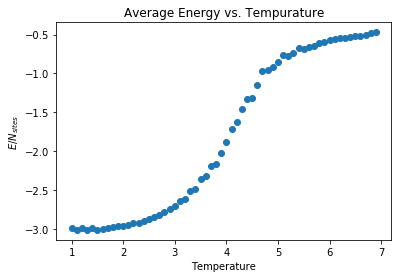

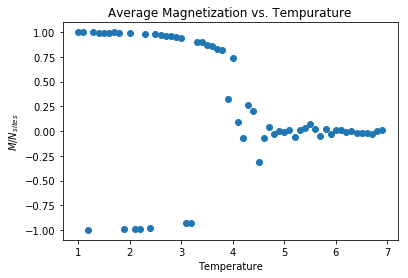

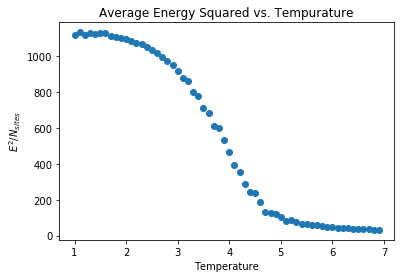

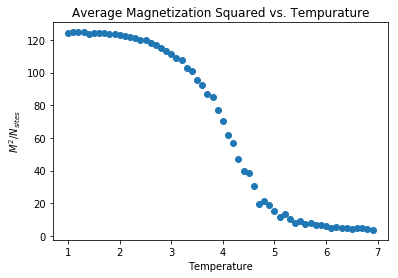

In [14]:
nFrames=1000
temperature = np.arange(1, 7, .1)
meanE=[]
meanM=[]
meanESq=[]
meanMSq=[]
for T in temperature:
    start = time.time()
    nSide = 5
    state = createRandState(nSide)
    finalState, ETemp, MTemp = ising3D(state, T, nFrames, 1)
    meanE.append(np.mean(ETemp))
    meanM.append(np.mean(MTemp))
    meanESq.append(np.mean(ETemp**2))
    meanMSq.append(np.mean(MTemp**2))
    end = time.time()
    print(f'Temperature {T} took {end-start} seconds to run {nFrames} frames')

plt.figure(0)
plt.plot(temperature, np.array(meanE)/(nSide*nSide*nSide),'o')
plt.title('Average Energy vs. Tempurature')
plt.xlabel('Temperature')
plt.ylabel('$E/N_{sites}$')

plt.figure(1)
plt.plot(temperature, np.array(meanM)/(nSide*nSide*nSide),'o')
plt.title('Average Magnetization vs. Tempurature')
plt.xlabel('Temperature')
plt.ylabel('$M/N_{sites}$')

plt.figure(2)
plt.plot(temperature, np.array(meanESq)/(nSide*nSide*nSide),'o')
plt.title('Average Energy Squared vs. Tempurature')
plt.xlabel('Temperature')
plt.ylabel('$E^2/N_{sites}$')

plt.figure(3)
plt.plot(temperature, np.array(meanMSq)/(nSide*nSide*nSide),'o')
plt.title('Average Magnetization Squared vs. Tempurature')
plt.xlabel('Temperature')
plt.ylabel('$M^2/N_{sites}$')